# Tutorial: Recurrence Networks

This tutorial introduces the analysis of non-linear timeseries via a complex network approach. The implementation of this methodology in the `pyunicorn` package is illustrated with two examples, showcasing the basic use of the classes `timeseries.Recurrence{Plot,Network}`.

## Introduction

### Recurrence Plots for the Analysis of Complex Systems

So far, the analysis of complex networks in different scientific fields has been performed by studying the adjacency matrix $A_{i,j}$. Recent work has been focussing on studying time series using a similar approach, by transforming the time series into a complex network and then analyzing the phase space and its properties using the **recurrence plot (RP)**.

The **recurrence matrix** can be considered as the adjacency matrix of an undirected, unweighted network. With this approach, it is possible to characterise the local and global properties of a network. 
In particular, it can be applied to *(i)* both univariate and multivariate time series (phase space trajectories), *(ii)* with and without pronounced oscillatory components, and *(iii)* with or without embedding. Moreover, similar to traditional **recurrence quantification analysis (RQA)**, studying network properties for sliding windows in time also allows for coping with non-stationary time series. Consequently, unlike for most of the existing techniques, there are no fundamental restrictions w.r.t. its practical applicability to arbitrary time series.

For more detailed background information, please consult [Marwan et al. (2009)](https://www.sciencedirect.com/science/article/abs/pii/S0375960109011852).

### Visualization of a Timeseries and its Recurrence Network

Before we get started, we shall visualize a timeseries based on a three dimensional chaotic oscillator example described by the Lorenz system:

$$\frac{d}{dt}(x,y,z)=\left( 10(y-x),x(28-z)-y,xy-\frac{8}{3}z \right) \,.$$

The following figures represent the timeseries in phase space and its RP.

![Recurrence Plot](images/REcurrencePlot_v2.png)

__(A)__ A state at time *i* (red dot) is recurrent at another time *j* (black dot) when the phase space trajectory visits its close neighbourhood (gray circle). This is marked by value 1 in the recurrence matrix at *(i, j)*. States outside of this neighbourhood (small red circle) are marked with 0 in the recurrence matrix.

__(B)__ Graphical representation of the corresponding recurrence matrix (recurrence plot).

For literature review and background information, see [Donner et al. (2010b)](https://www.worldscientific.com/doi/abs/10.1142/S0218127411029021).

### Correspondence Between Recurrence Networks and Phase Space Measurements

The following table shows how some of the characteristics measured from a recurrence network translate into corresponding phase space features of the time series. For more background information, consult [Donges et al. (2012)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.85.046105).


| Scale | Recurrence Network | Phase space interpretation |
| :--- | :--- | :--- |
| Local | Continuous local $\epsilon$-clustering coefficient | Local dimension | 
| Local | Continuous $\epsilon$-matching index | Local density gradient | 
| Global | Continuous $\epsilon$-transitivity | Global dimension  | 
| Global | Continuous global $\epsilon$-clustering | Average local dimension | 

## Example: Logistic Map

First, we import the necessary packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pyunicorn.timeseries import RecurrenceNetwork, RecurrencePlot

We create a function to calculate a logistic map timeseries:

In [2]:
def logistic_map(x0: float, r: float, T: int, spinup: int = 100):
    """
    Returns a time series of length T using the logistic map
    x_(n+1) = r*x_n(1-x_n)
    at parameter r and using the initial condition x0.
    
    INPUT: x0 - Initial condition, 0 <= x0 <= 1
            r - Bifurcation parameter, 0 <= r <= 4
            T - length of the desired time series
            spinup - number of spinup-timesteps before storing results to output
    OUTPUT: numpy array of timeseries under given parameters
    """
    # spinup
    for n in range(spinup):
        x0 = r * x0 * (1 - x0)
    
    timeseries = np.zeros(T + 1)
    timeseries[0] = x0
    for n in range(T):
        # get current timestep value
        xn = timeseries[n]
        # calculate next timestep value
        xstep = r * xn * (1 - xn)
        timeseries[n + 1] = xstep
    return timeseries

After choosing the bifurcation parameter $r$, the initial value $x_0$ and the length of the timeseries $T$, we can now generate a timeseries. Play around with the parameters if you like! For an interesting regime, we should stick with $r >3.6$.
**Note:** Our `logistic_map()` function includes a spinup of 100 timesteps by default, so the resulting timeseries will not start at $x_0$.

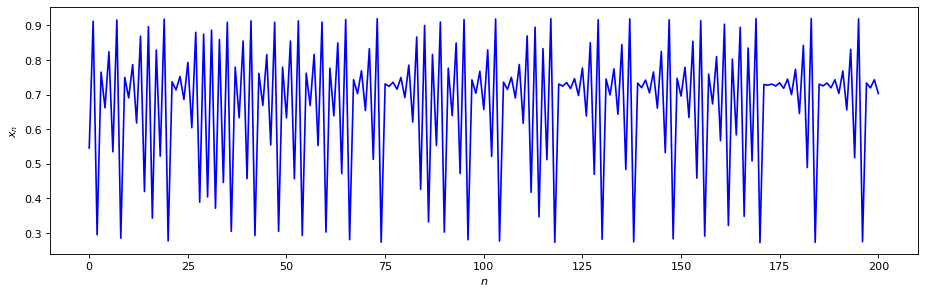

In [3]:
#  Parameters of logistic map
r = 3.679  # Bifurcation parameter
x0 = 0.7   # Initial value
#  Length of the time series
T = 200
#  Generate the timeseries
time_series = logistic_map(x0, r, T)
#  Plot the time series
plt.figure(figsize=(14, 4), dpi=80)
plt.plot(time_series, "b")
plt.xlabel("$n$")
plt.ylabel("$x_n$");

### Recurrence Properties Under Fixed Recurrence Threshold $\epsilon$

Now we can create a RP from our time series using the `timeseries.RecurrenePlot` class. Following [Marwan et al. (2009)](https://www.sciencedirect.com/science/article/abs/pii/S0375960109011852), we choose a fixed recurrence threshold $\epsilon$ that is 5% of the time series' standard deviation. For that purpose, we set the parameter `threshold_std`. **Note:** For a one-dimensional timeseries we do not use embedding.

Calculating recurrence plot at fixed threshold in units of time series STD...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


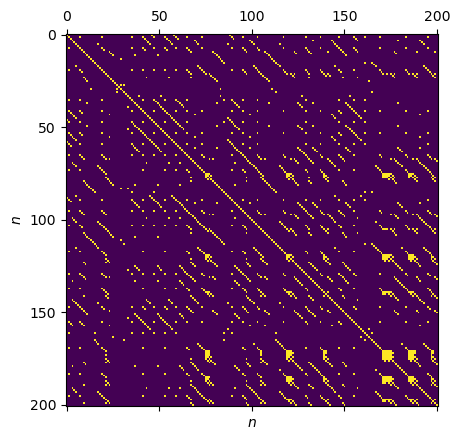

In [4]:
# Fixed recurrence threshold in units of the time series' standard deviation
EPS_std = 0.05
# Default distance metric in phase space: "supremum"
# Can also be set to "euclidean" or "manhattan".
METRIC = "supremum"
rp = RecurrencePlot(time_series, metric=METRIC,
                    normalize=False, threshold_std=EPS_std)
plt.matshow(rp.recurrence_matrix())
plt.xlabel("$n$"); plt.ylabel("$n$");

Some of the main properties of a RP can be easily extracted with the `rqa_summary()` method:

In [5]:
rp.rqa_summary()

{'RR': 0.05061755897131259,
 'DET': 0.7494577006466949,
 'L': 3.971264367701975,
 'LAM': 0.10953545232220277}

#### Network Calculation

Now we can use the recurrence properties, which mimic the phase space properties of the original time series, to calculate quantitative characteristics of the time series implicitly. We shall distinghuish here between *local*, *intermediate* and *global* properties. In order to construct the complex network we use the `timeseries.RecurrenceNetwork` class, which combines the `timeseries.RecurrencePlot` and `core.Network` charactistics. For more information on the individual properties, see [Donner et al. (2010a)](https://iopscience.iop.org/article/10.1088/1367-2630/12/3/033025/meta). 

Our main focus will lie on determining the local and global clustering coefficient as well as the network transitivity. 

In [6]:
rn = RecurrenceNetwork(time_series, metric=METRIC,
                       normalize=False, threshold_std=EPS_std)

Calculating recurrence plot at fixed threshold in units of time series STD...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


#### Local Clustering Coefficient

The local scale network properties consider only the direct neighbourhood within a defined $\epsilon$-ball of a vertex $v$.
A __local clustering coefficient__ $C_v$ characterizes the density of connections in the direct neighbourhood of $v$ in terms of the density of connections between all vertices that are incident with $v$. In particular, we consider the clustering coefficient by Watts and Strogatz,

$$C_v=\frac{2}{k_v(k_v-1)}N^\Delta_v \,,$$

where $N^\Delta_v$ represents the number of closed triangles including vertex $v$, and $k_v$ stands for the local recurrence rate around $v$.

Calculating local clustering coefficients...


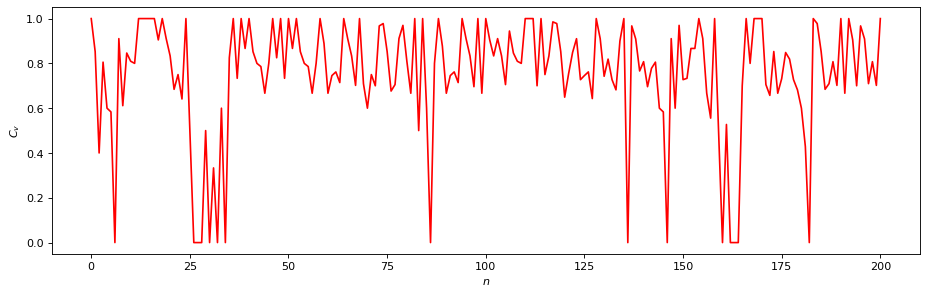

In [7]:
C_v = rn.local_clustering()

plt.figure(figsize=(14, 4), dpi=80)
plt.plot(C_v, "r")
plt.xlabel("$n$"); plt.ylabel("$C_v$");

#### Global Clustering Coefficient and Network Transitivity

In contrast, global scale network properties take all vertices into account.
The __global clustering coefficient__ is defined as the average value of the clustering coefficient taken over all vertices of a network,

$$C=\frac{1}{N}\sum_{v=1}^{N}C_v \,.$$

In [8]:
print(f"C = {rn.global_clustering()}")

Calculating the global clustering coefficient (C_2)...
C = 0.7532331807249787


The __transitivity__ of a network measures the probability that two neighbours (i.e., recurrences) of any state are also neighbours. It can be calculated from the link matrix $A_{i,j}$ of the network as

$$T = \frac{\sum_{i,j,k=1}^N A_{i,j}A_{j,k}A_{k,i}}{\sum_{i,j,k=1}^N A_{i,j}A_{k,i}}\,,$$

where $A_{i,j} = R_{i,j} - \delta_{i,j}$ with the recurrence matrix $R_{i,j}$ and the Kronecker-delta $\delta_{i,j}$.

In [9]:
print(f"T = {rn.transitivity()}")

Calculating transitivity coefficient (C_1)...
T = 0.8021460350693536


### Recurrence Properties Under Fixed Recurrence Rate $RR$

For comparison, we now calculate the same recurrence properties using a fixed recurrence rate.

Calculating recurrence plot at fixed recurrence rate...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed recurrence rate...
Calculating the supremum distance matrix...
Calculating local clustering coefficients...
Calculating the global clustering coefficient (C_2)...
C = 0.7544336150477271
Calculating transitivity coefficient (C_1)...
T = 0.8005944339367739


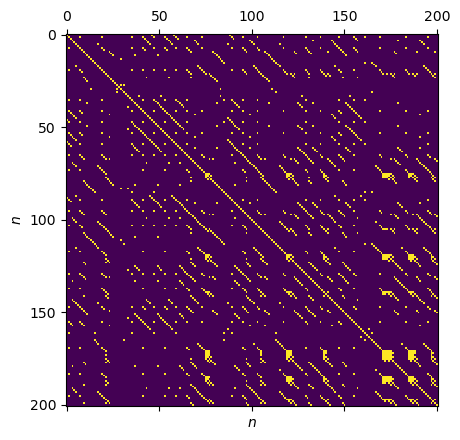

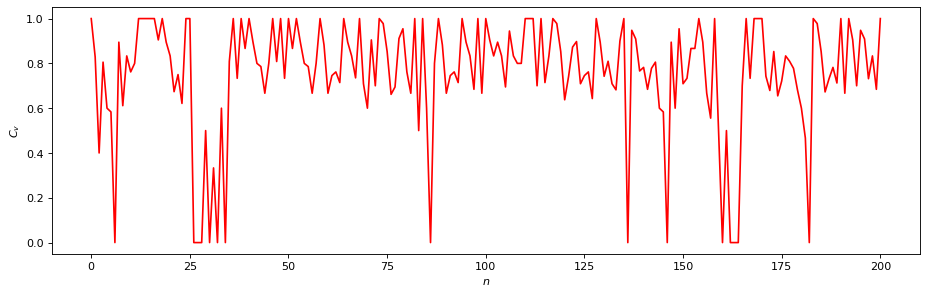

In [10]:
# choose fixed recurrence rate
RR = 0.05
METRIC = "supremum"
rp = RecurrencePlot(time_series, metric=METRIC,
                    normalize=False, recurrence_rate=RR)
plt.matshow(rp.recurrence_matrix())
plt.xlabel("$n$"); plt.ylabel("$n$");

rn = RecurrenceNetwork(time_series, metric=METRIC,
                       normalize=False, recurrence_rate=RR)
# Local measures: 
# - Local Clustering Coefficients
C_v = rn.local_clustering()
plt.figure(figsize=(14, 4), dpi=80)
plt.plot(C_v, "r")
plt.xlabel("$n$"); plt.ylabel("$C_v$");

# Global measures:
# - Global Clustering Coefficient
print(f"C = {rn.global_clustering()}")
# - Transitivity
print(f"T = {rn.transitivity()}")

## Example: Lorenz Attractor

In this example, we will be using the chaotic Lorenz system as defined in the introduction.

In [11]:
def Lorenz_timeseries(dt=0.01, num_steps=10000, x0=0., y0=1., z0=1.05,
                      s=10., r=28., b=2.667, spinup=1000):
    """
    Given:
      dt: length of timestep
      num_steps: number of timesteps
      x0, y0, z0: initial values for timeseries
      s, r, b: parameters defining the lorenz attractor
      spinup: number of spinup-timesteps before storing results to output
    Returns:
      timeseries: numpy array of three dimensional timeseries on Lorenz attractor
                  with length num_steps
    """
    # define integrator
    def step(x):
        v = np.array([s*(x[1] - x[0]),
                      r*x[0] - x[1] - x[0]*x[2],
                      x[0]*x[1] - b*x[2]])
        return x + v * dt
    # initialize
    X = np.array([x0, y0, z0], dtype=np.float64)
    # spinup
    for n in range(spinup):
        X = step(X)
    # observe timeseries
    timeseries = np.zeros((num_steps, len(X)))
    timeseries[0] = X
    for n in range(num_steps-1):
        timeseries[n + 1] = step(timeseries[n])
    return timeseries

Now we calculate a timeseries on the Lorenz attractor with the defined function. Try different timesteps, initial values and Lorenz parameters, or just use the default ones defined above.

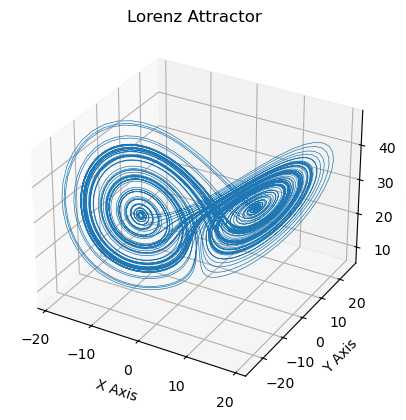

In [12]:
lorenz = Lorenz_timeseries()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(*lorenz.T, lw=0.5)
ax.set_xlabel("X Axis"); ax.set_ylabel("Y Axis"); ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor");

### Recurrence Properties

We first calculate the RP of this three-dimensional timeseries for a fixed recurrence rate.

In [13]:
RR = 0.05
lorenz_rp = RecurrencePlot(lorenz, recurrence_rate=RR, metric=METRIC)

Calculating recurrence plot at fixed recurrence rate...
Calculating the supremum distance matrix...


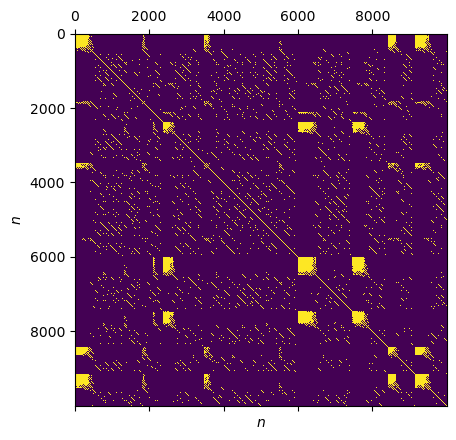

In [14]:
plt.matshow(lorenz_rp.recurrence_matrix())
plt.xlabel("$n$"); plt.ylabel("$n$")

#### Local Clustering Coefficient

From the local clustering coefficient we can calculate the local clustering dimension:
$$CD_v=\frac{log(C_v)}{log(\frac{3}{4})}\,.$$

In [15]:
lorenz_rn = RecurrenceNetwork(lorenz, recurrence_rate=RR, metric=METRIC)
lorenz_C_v = lorenz_rn.local_clustering()
print(f"C_v = {lorenz_C_v}")
CD_v = np.log(lorenz_C_v) / np.log(3/4)
print(f"CD_v = {CD_v}")

Calculating recurrence plot at fixed recurrence rate...
Calculating the supremum distance matrix...
Calculating local clustering coefficients...
C_v = [0.81391066 0.81240007 0.81127381 ... 0.53332127 0.53707695 0.53951554]
CD_v = [0.7157369  0.72219436 0.72701667 ... 2.1851597  2.16076691 2.14501963]


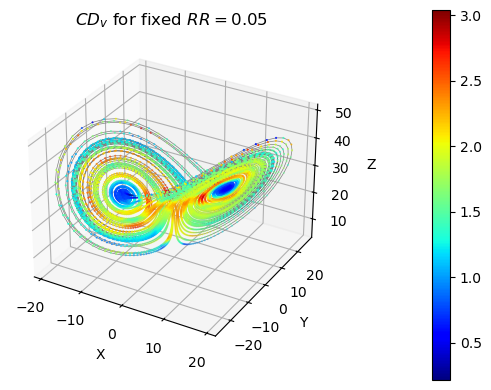

In [16]:
# plot trajectory on Lorenz attractor
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*lorenz.T, lw=0.5, color="grey")
# plot local clustering dimension
scat_plot = ax.scatter(*lorenz.T, lw=0.5, c=CD_v, s=1, cmap=plt.colormaps["jet"])
cb = plt.colorbar(scat_plot, pad=0.2)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title(f"$CD_v$ for fixed $RR = {RR}$");

#### Global clustering coefficient

Similarly to the local case, we can calculate the global clustering coefficient of the Lorenz timeseries and obtain its global clustering dimension as:
$$CD=\frac{log(C)}{log(\frac{3}{4})}\,.$$

In [17]:
C = lorenz_rn.global_clustering()
print(f"C = {C}")
CD = np.log(C) / np.log(3/4)
print(f"CD = {CD}")

Calculating the global clustering coefficient (C_2)...
C = 0.6420799584495237
CD = 1.5400418712226018


#### Transitivity

Lastly, we can calculate the transitivity $T$ and its corresponding dimension $TD$ analogously.

In [18]:
lorenz_T = lorenz_rn.transitivity() 
print(f"T = {lorenz_T}")
TD = np.log(lorenz_T) / np.log(3/4)
print(f"TD = {TD}")

Calculating transitivity coefficient (C_1)...
T = 0.7217193610758386
TD = 1.1336087419104863


### Bonus Exercise: Transitivity Dimension as a Function of Recurrence Rate

We can also calculate the transitivity dimension for an array of different recurrence rates. **Note:** This might take a while to finish.

In [19]:
%%time

# define grid of recurrence rates
# rr = np.arange(0.02, .22, 0.04) # for a quick test (ca. 2 min)
rr = np.arange(0.02, .42, 0.04) # for a more extensive calculation (ca. 10 min)

# calculate transitivity dimensions (with progressbar)
TD = []
for r in tqdm(rr):
    T_r = RecurrenceNetwork(lorenz, recurrence_rate=r, metric=METRIC,
                            silence_level=2).transitivity()
    TD.append(np.log(T_r) / np.log(3/4))

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 8min 47s, sys: 18.6 s, total: 9min 6s
Wall time: 9min 2s


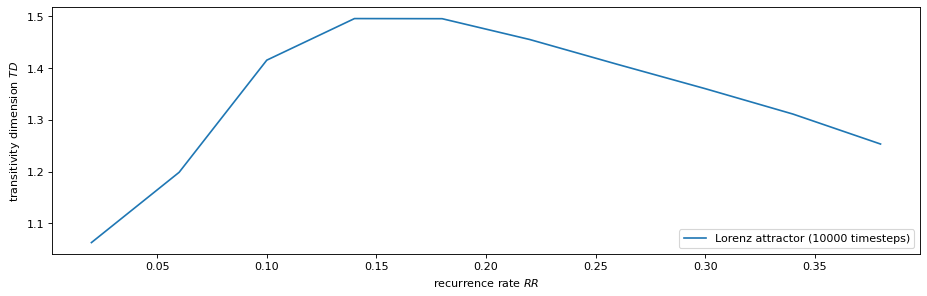

In [20]:
plt.figure(figsize=(14, 4), dpi=80)
plt.plot(rr, TD, label= "Lorenz attractor (10000 timesteps)") 
plt.xlabel('recurrence rate $RR$')
plt.ylabel('transitivity dimension $TD$')
plt.legend(loc = "lower right");